In [1]:
# Let’s use the read_csv() in pandas package to read the time series dataset (a csv file on Australian Drug Sales) as a pandas dataframe.
# Adding the parse_dates=['date'] argument will make the date column to be parsed as a date field.

from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Import as Dataframe
df = pd.read_csv('sample_data.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [3]:
# Alternately, you can import it as a pandas Series with the date as index.
# You just need to specify the index_col argument in the pd.read_csv() to do this.

df = pd.read_csv('sample_data.csv', parse_dates=['date'], index_col='date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


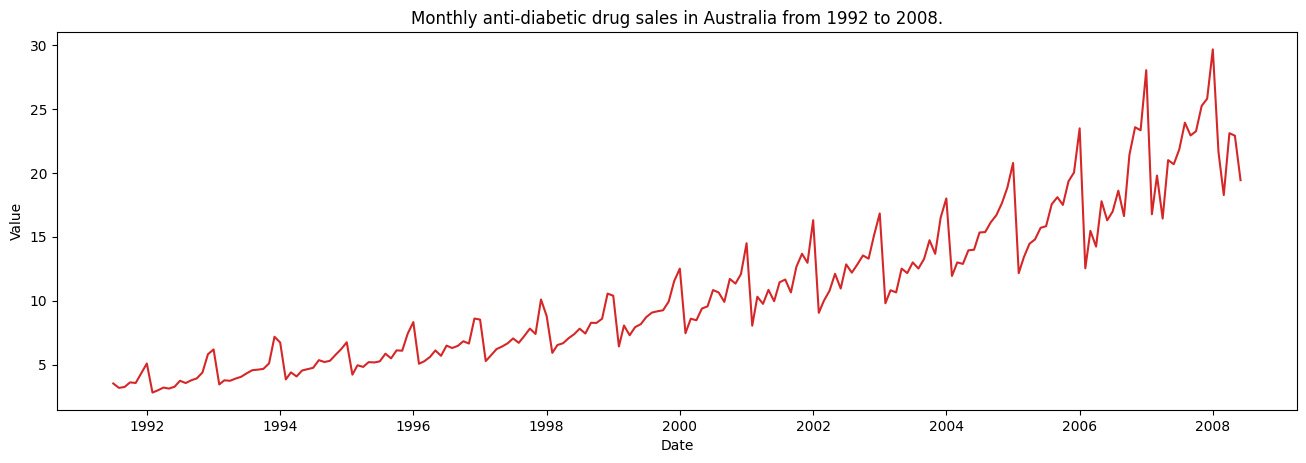

In [4]:
# Visualizing a time series - Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

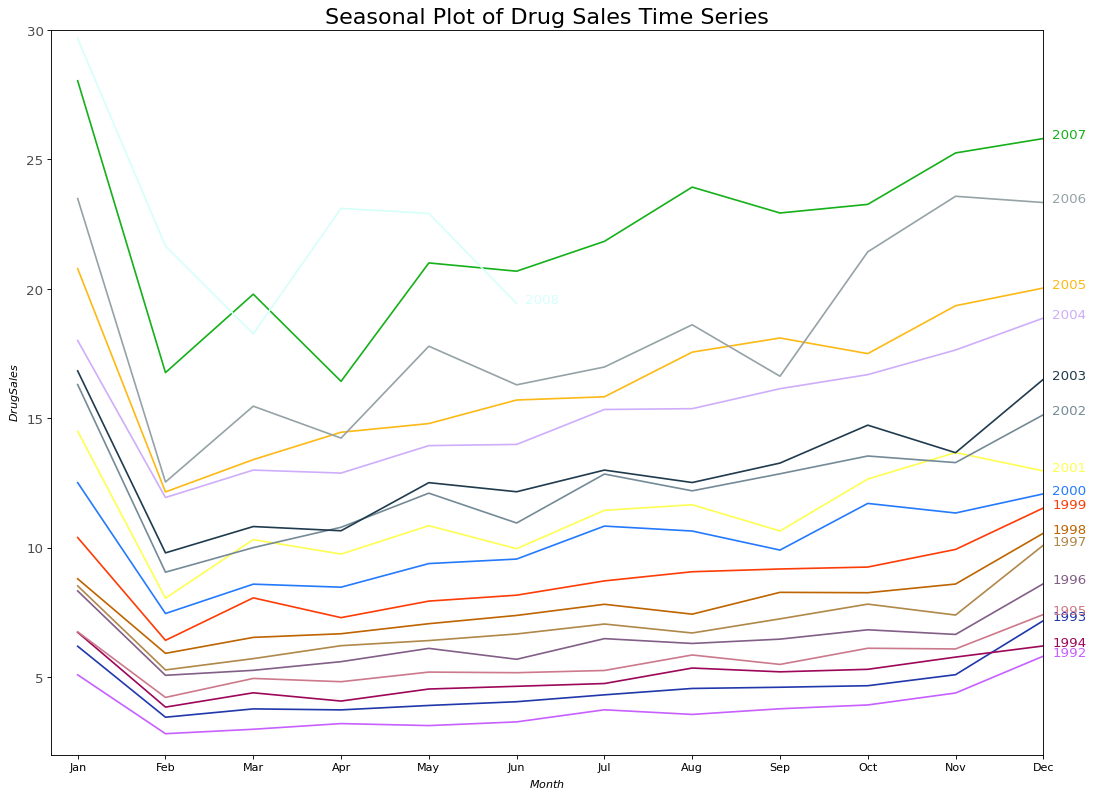

In [5]:
# Seasonal Plot of a Time Series
# Since its a monthly time series and follows a certain repetitive pattern every year, you can plot each year as a separate line in the
# same plot. This lets you compare the year wise patterns side-by-side.

# Import Data
df = pd.read_csv('sample_data.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

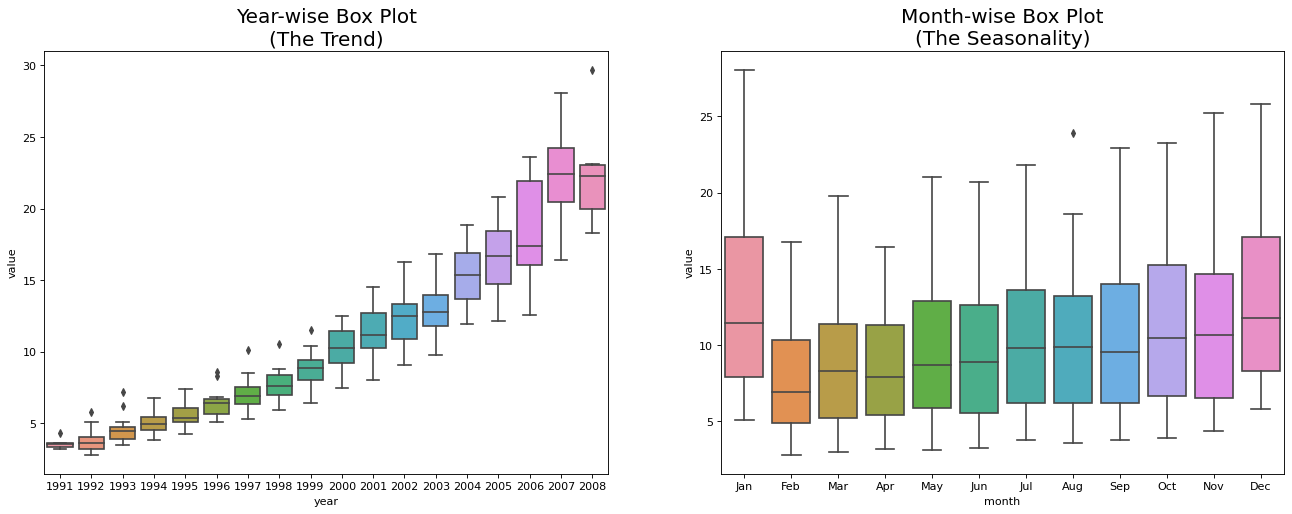

In [13]:
# Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution
# You can group the data at seasonal intervals and see how the values are distributed within a given year or month and how it compares over time.
# Import Data
df = pd.read_csv('sample_data.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

<AxesSubplot:title={'center':'Trend and Seasonality'}, xlabel='date'>

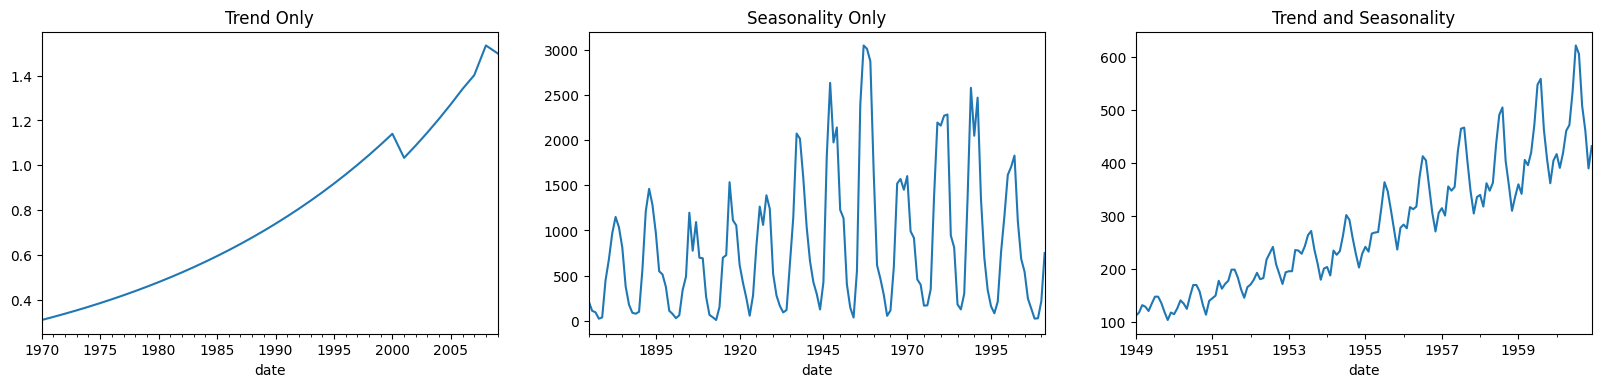

In [14]:
# Patterns in a time series

fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])


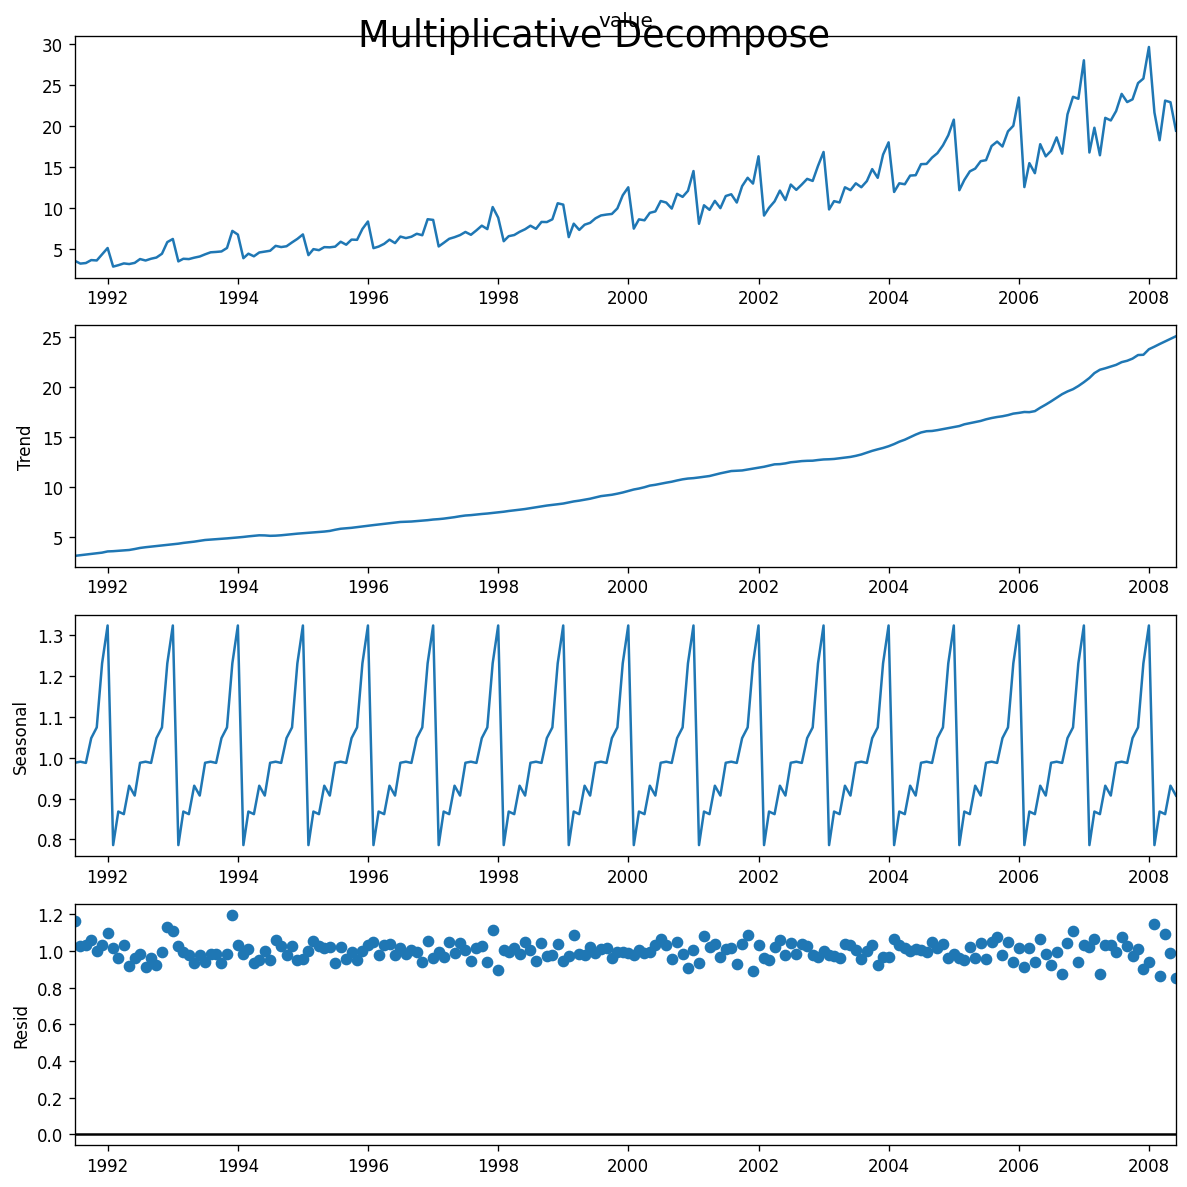

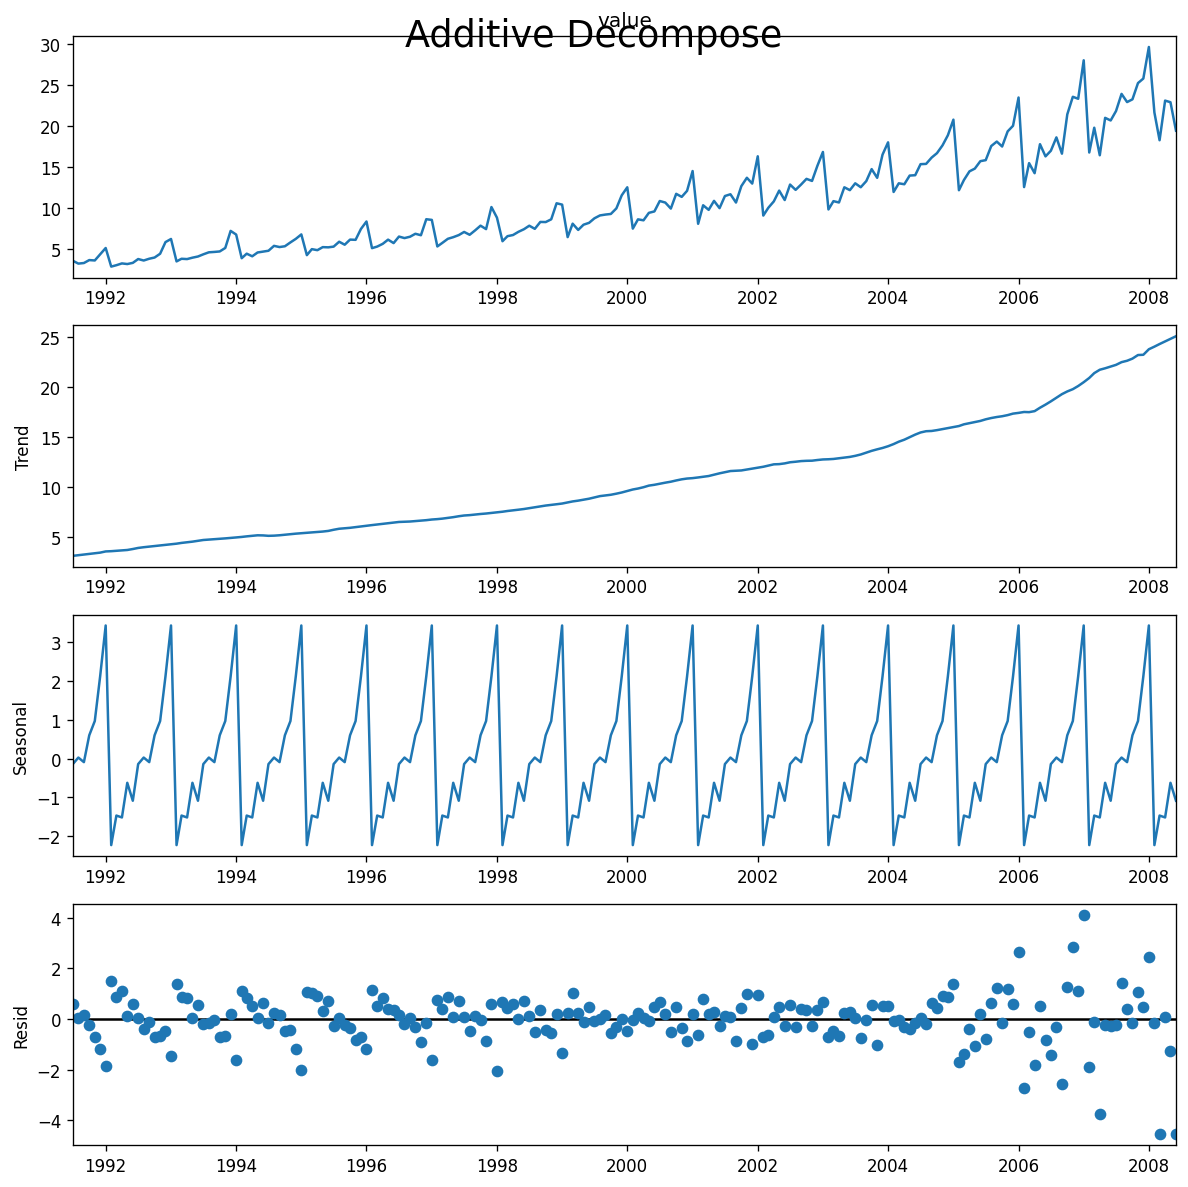

In [15]:
# decompose a time series into its components
# Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series.

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()


In [16]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()


,seas,trend,resid,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


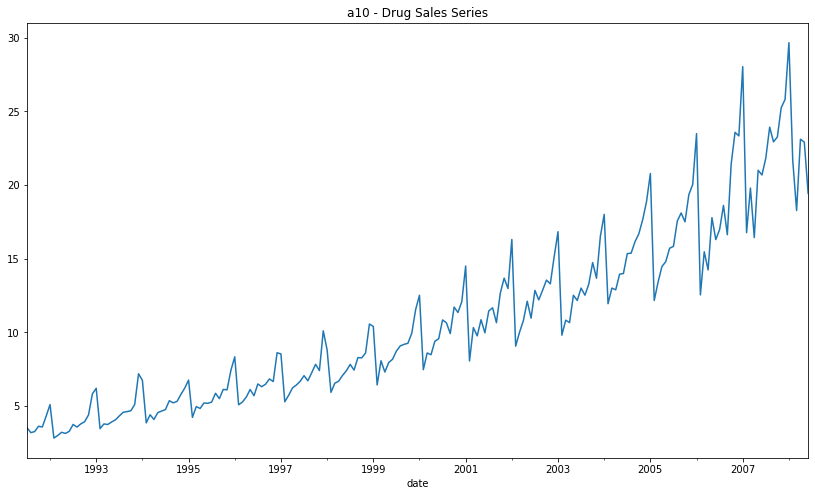

In [18]:
# ADF Test

# Setup and Import data
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
%matplotlib inline

url = 'https://raw.githubusercontent.com/selva86/datasets/master/a10.csv'
df = pd.read_csv(url, parse_dates=['date'], index_col='date')
series = df.loc[:, 'value'].values
df.plot(figsize=(14,8), legend=None, title='a10 - Drug Sales Series');

# An optional argument the adfuller() accepts is the number of lags you want to consider while performing the OLS regression.
# By default, this value is 12*(nobs/100)^{1/4}, where nobs is the number of observations in the series. But, optionally you can specify either the maximum number of lags with maxlags parameter or let the algorithm compute the optimal number iteratively.
# This can be done by setting the autolag='AIC'. By doing so, the adfuller will choose a the number of lags that yields the lowest AIC. This is usually a good option to follow.

In [20]:
# ADF Test for non-stationary series
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.
# Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.


ADF Statistic: 3.1451856893067363
n_lags: 1.0
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


In [ ]:
# ADF Test for stationary series
series = np.random.randn(100)
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.
# Let’s visualise the series as well to confirm.

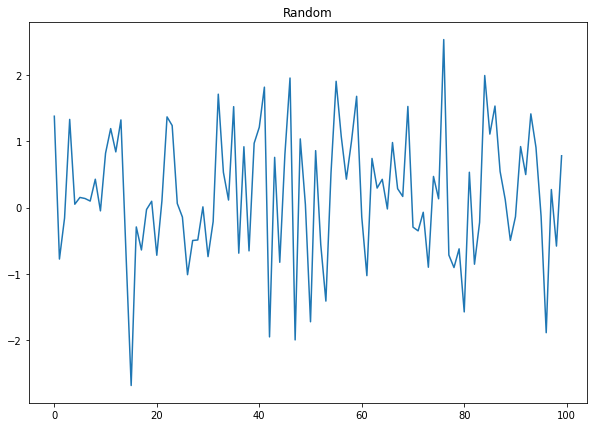

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(series);
plt.title('Random');

Text(0.5, 1.0, 'Drug Sales without detrended')

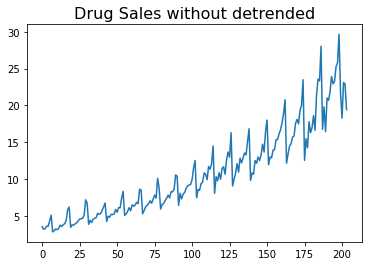

In [30]:
# detrending the series
# Using scipy: Subtract the line of best fit
from scipy import signal
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
detrended = signal.detrend(df.value.values)
plt.plot(df.value.values)
plt.title('Drug Sales without detrended', fontsize=16)
#plt.plot(detrended)
#plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)


Text(0.5, 1.0, 'Drug Sales detrended by subtracting the least squares fit')

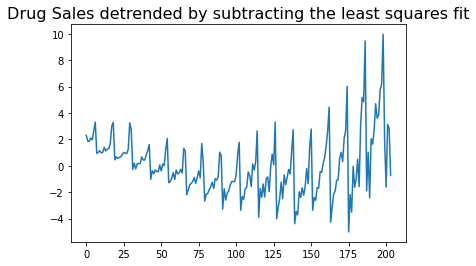

In [31]:
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

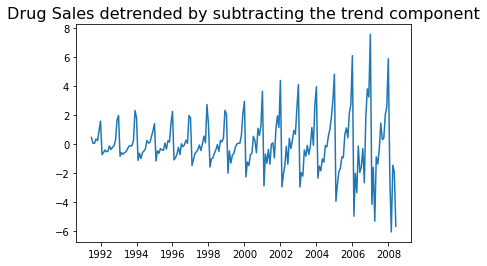

In [32]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

[]

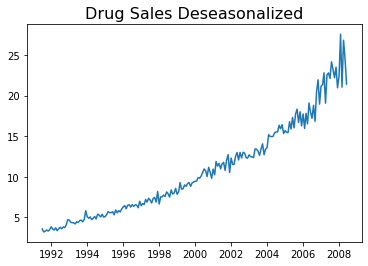

In [33]:
# deseasonal the series
# Subtracting the Trend Component.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Time Series Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df.value.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

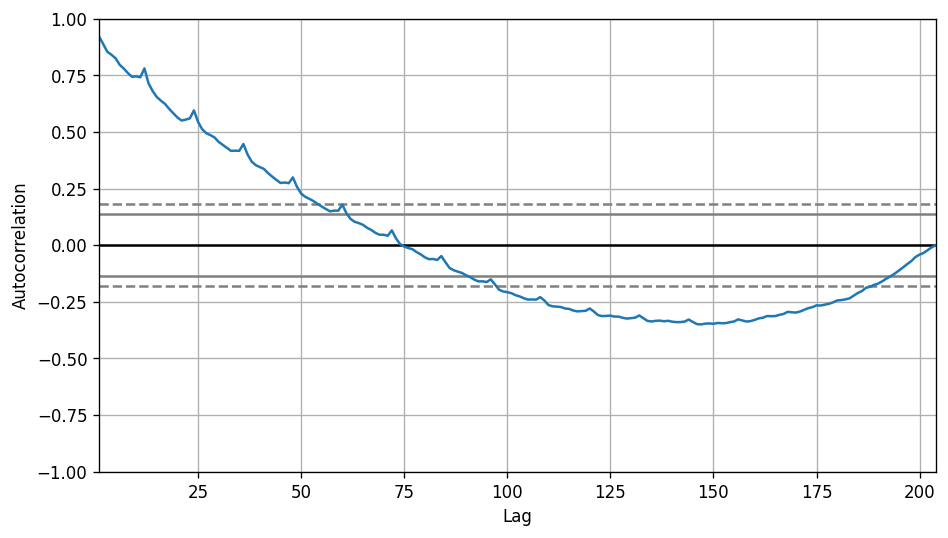

In [35]:
# ACF plot
from pandas.plotting import autocorrelation_plot
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())

In [43]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [39]:
import matplotlib.pyplot as plt 

(array([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,
         -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,
         -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,
         -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,
         -56,  -55,  -54,  -53,  -52,  -51,  -50,  -49,  -48,  -47,  -46,
         -45,  -44,  -43,  -42,  -41,  -40,  -39,  -38,  -37,  -36,  -35,
         -34,  -33,  -32,  -31,  -30,  -29,  -28,  -27,  -26,  -25,  -24,
         -23,  -22,  -21,  -20,  -19,  -18,  -17,  -16,  -15,  -14,  -13,
         -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,
          -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
          10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
          21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
          32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
          43,   44,   45,   46,   47, 

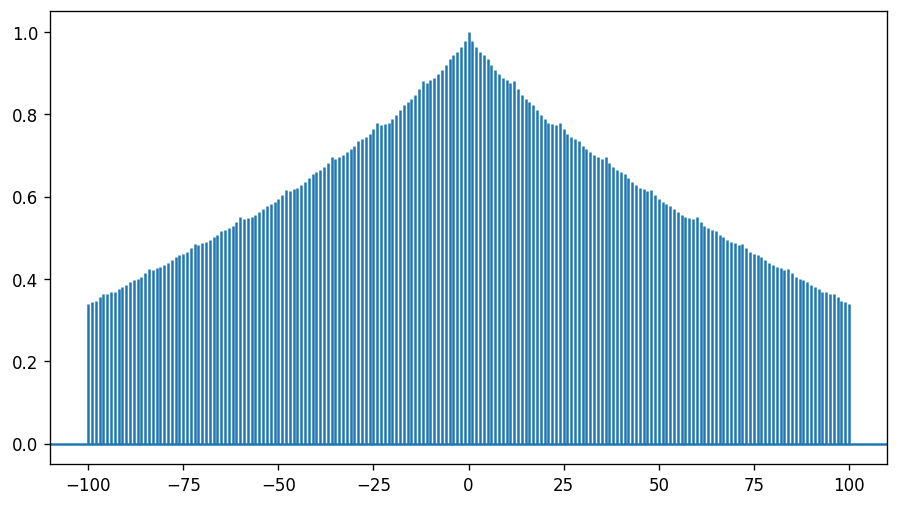

In [44]:
plt.acorr(df['value'], maxlags = 20)

<AxesSubplot:title={'center':'Seasonal Mean (MSE: 1.16)'}, xlabel='date'>

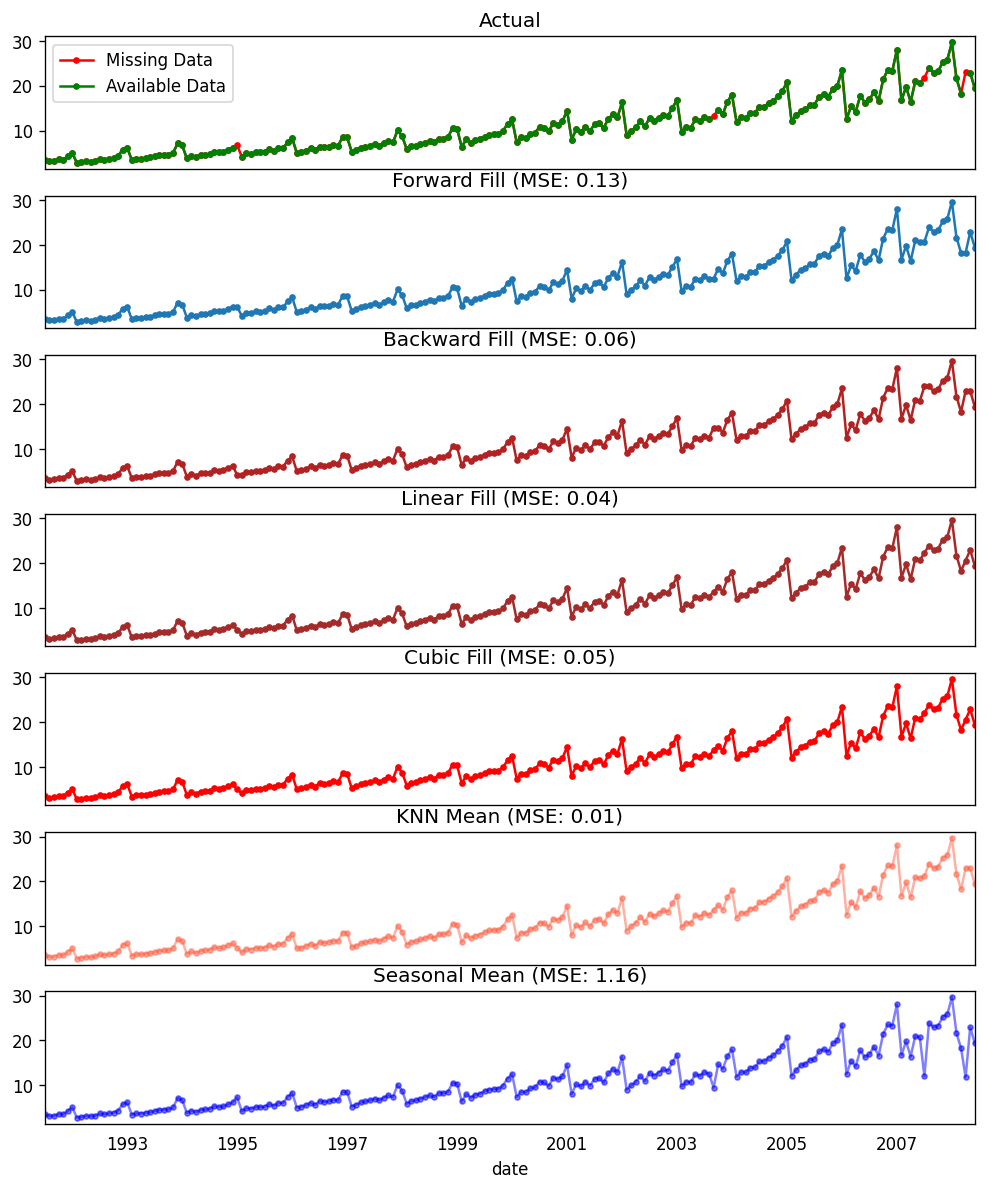

In [65]:
# missing value handling

# # Generate dataset
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
df_orig = pd.read_csv('sample_data.csv', parse_dates=['date'], index_col='date')
df = pd.read_csv('sample_data_missing.csv', parse_dates=['date'], index_col='date')

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")

,value,rownum
date,,
2008-01-01,29.665356,198
2008-02-01,21.654285,199
2008-03-01,18.264945,200
2008-05-01,22.912510,202
2008-06-01,19.431740,203


,value,rownum,linear_fill
date,,,
2008-02-01,21.654285,199,21.654285
2008-03-01,18.264945,200,18.264945
2008-04-01,NaN,201,20.588728
2008-05-01,22.912510,202,22.912510
2008-06-01,19.431740,203,19.431740
